In [1]:
# import the necessary packages
from keras.applications import ResNet50, VGG16
from keras.applications import imagenet_utils

from keras.layers import Flatten, Dense, GlobalAveragePooling2D, Dropout, Convolution2D, MaxPooling2D, Activation, Input
from keras.models import Sequential, Model
from keras.callbacks import History, ModelCheckpoint

from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img

from keras.optimizers import Adadelta, Adagrad, Adam, Adamax, Nadam

from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from keras.utils.np_utils import to_categorical

import numpy as np
import matplotlib.pyplot as plt

import h5py
from glob import glob
import string
from PIL import Image

import cv2

Using TensorFlow backend.


In [2]:
bottleneck_feature = np.load("../bottleneck_features/res_features_train.npy")
bottleneck_feature.shape


(1555, 1, 1, 2048)

In [3]:
bottleneck_labels = np.load("../bottleneck_features/res_bottle_labels.npy")
bottleneck_labels.shape



(1555,)

In [4]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=123)

X = bottleneck_feature.copy()
y = bottleneck_labels.copy()

for train_index, test_index in sss.split(X, y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

print (X_train.shape, X_test.shape)

(1166, 1, 1, 2048) (389, 1, 1, 2048)


In [5]:
from keras.utils.np_utils import to_categorical

train_labels = to_categorical(y_train, num_classes=26)
test_labels = to_categorical(y_test, num_classes=26)



In [6]:
nb_epoch = 30
batch_size = 32

top_model = Sequential()
top_model.add(Flatten(input_shape=X_test.shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(26, activation='softmax'))

top_model.compile(optimizer = Adamax(),
                  loss ='categorical_crossentropy',
                  metrics =['accuracy'])



In [ ]:
filepath = '../bottleneck_features/bottleneck_top_model.h5'

save_snapshots = ModelCheckpoint(filepath,
                                 monitor='val_acc',
                                 save_best_only=True,
                                 save_weights_only=True,
                                 mode='max',
                                 verbose=1)

callbacks_list = [save_snapshots] 

history = top_model.fit(X_train, train_labels,
          epochs = nb_epoch, 
          batch_size = 1,
          callbacks = callbacks_list,
          validation_data=(X_test, test_labels))

In [ ]:
nb_epoch = 30
batch_size = 32

In [32]:
top_model(model.output)

<tf.Tensor 'sequential_3/dense_6/Softmax:0' shape=(?, 26) dtype=float32>

### TEST ON REAL EXAMPLE

In [7]:
#ResNet/other net - you need to define the input tensor shape 
model = ResNet50(include_top=False, input_tensor=Input(shape=(224,224,3)))

#Classification block
top_model = Sequential()
top_model.add(Flatten(input_shape=model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(26, activation='softmax'))

top_model_weights_path = '../bottleneck_features/bottleneck_top_model.h5'
top_model.load_weights(top_model_weights_path)

###
my_model = Model(inputs=model.input, outputs = top_model(model.output))
my_model

### https://github.com/fchollet/deep-learning-models/issues/24

In [8]:
res_model = ResNet50(include_top=False)

In [9]:
top_model = Sequential()
top_model.add(Flatten(input_shape=X_test.shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(26, activation='softmax'))

#top_model.compile(optimizer = Adamax(),
#                  loss ='categorical_crossentropy',
#                  metrics =['accuracy'])

top_model_weights_path = '../bottleneck_features/bottleneck_top_model.h5'
top_model.load_weights(top_model_weights_path)



In [6]:
# STEP 0 - load image

img_a = Image.open("../sample_data/test_a.jpg")
img_b = Image.open("../sample_data/test_b.jpg")
img_e = Image.open("../sample_data/test_e.jpg")

a = preprocess_for_vgg(img_a)
b = preprocess_for_vgg(img_b)
e = preprocess_for_vgg(img_e)


In [17]:

res_model = ResNet50(include_top=False)

vgg_model = ResNet50(include_top=False)



In [23]:
%timeit res_model.predict(a)

1 loop, best of 3: 235 ms per loop


In [24]:
%timeit vgg_model.predict(a)

1 loop, best of 3: 233 ms per loop


In [17]:
import cv2

cv_img_a = cv2.imread("../sample_data/test_a.jpg")
cv_img_b = cv2.imread("../sample_data/test_b.jpg")
cv_img_e = cv2.imread("../sample_data/test_e.jpg")


In [19]:
image_list = [a, b, e]

In [38]:
for image in image_list:
    
    predictions = my_model.predict(image)
    top_prd = np.argmax(predictions)
    
    if np.max(predictions) >= 0.95:
        print ("prediction: " + predict_class[top_prd], 
               "    probability: " + str(np.max(predictions)))
    else:
        print ("no classification!")

prediction: c     probability: 0.999997
prediction: c     probability: 0.995845
prediction: c     probability: 0.999974


In [37]:
#convert class letters to integer values

predict_class = {}

for pos,letter in enumerate(string.ascii_lowercase):
    predict_class[pos] = letter

for image in image_list:
    
    #~232 ms
    step_1 = my_model.predict(image)
    #step 2 - run extracted features through classification block
    # 1.04 ms
    predictions = top_model.predict(step_1, 
                                    batch_size = step_1.shape[0])

    top_prd = np.argmax(predictions)
    if np.max(predictions) >= 0.95:
        print ("prediction: " + predict_class[top_prd], 
               "    probability: " + str(np.max(predictions)))
    else:
        print ("no classification!")
    
    

prediction: c     probability: 0.999997
prediction: c     probability: 0.995845
prediction: c     probability: 0.999974


ValueError: Error when checking : expected input_1 to have shape (None, 224, 224, 3) but got array with shape (1, 1, 1, 2048)

In [25]:
#convert class letters to integer values

predict_class = {}

for pos,letter in enumerate(string.ascii_lowercase):
    predict_class[pos] = letter

for image in image_list:
    
    my_predict = my_model.predict(image, 
                                  batch_size= 1,
                                  verbose=0)
    top_prd = np.argmax(my_predict)
    print (predict_class[top_prd])

c
c
c
l
c
l


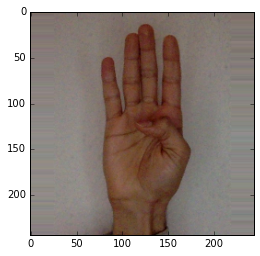

In [77]:
crop_img = cv_img_b[83:650, 314:764] # Crop from x, y, w, h -> 100, 200, 300, 400
#invert_crop_img = crop_img[:,:,[2,1,0]]
pad_crop_img_b = square_pad(crop_img)
resize_img_b = cv2.resize(pad_crop_img_b, (244,244))
plt.imshow(resize_img_b[:,:,::-1])
plt.show()


In [78]:
x=np.array(resize_img_b, dtype='float')
x[ :, :, 0] -= 103.939
x[ :, :, 1] -= 116.779
x[ :, :, 2] -= 123.68
plt.imshow(x[:,:,[2,1,0]])

In [ ]:
test = resize_img_b.copy()
test = cv2.cvtColor(test, cv2.COLOR_BGR2GRAY)
ret,thresh2 = cv2.threshold(test,90,255,cv2.THRESH_BINARY_INV)
plt.imshow(thresh2)
plt.show()

In [ ]:
test = resize_img_b.copy()
test[test>100]=255
plt.imshow(test[:,:,[2,1,0]])
plt.show()

In [95]:
#skin detect

frame = resize_img_b.copy()

# define the upper and lower boundaries of the HSV pixel
# intensities to be considered 'skin'
lower = np.array([0, 48, 80], dtype = "uint8")
upper = np.array([20, 255, 255], dtype = "uint8")

In [96]:
# onvert it to the HSV color space,
# and determine the HSV pixel intensities that fall into
# the speicifed upper and lower boundaries

converted = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
skinMask = cv2.inRange(converted, lower, upper)

# apply a series of erosions and dilations to the mask
# using an elliptical kernel
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
#skinMask = cv2.erode(skinMask, kernel, iterations = 2)
#skinMask = cv2.dilate(skinMask, kernel, iterations = 2)
#skinMask = cv2.morphologyEx(skinMask, cv2.MORPH_OPEN, kernel)
# blur the mask to help remove noise, then apply the
# mask to the frame
skinMask = cv2.GaussianBlur(skinMask, (3, 3), 0)
skin = cv2.bitwise_and(frame, frame, mask = skinMask)

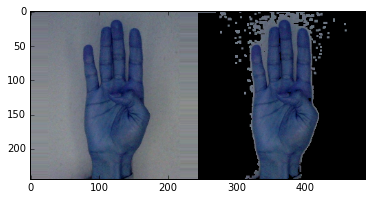

In [97]:
# show the skin in the image along with the mask
plt.imshow(np.hstack([frame, skin]))
plt.show()


In [ ]:
img_b.size[0] / 2, img_b.size[1] / 2

img4 = img_b.crop((340, 100, 740, 600))


In [ ]:
#http://docs.opencv.org/3.2.0/d8/d83/tutorial_py_grabcut.html


In [ ]:
img = resize_img_b

ret,thresh1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
ret,thresh2 = cv2.threshold(img,127,255,cv2.THRESH_BINARY_INV)
ret,thresh3 = cv2.threshold(img,127,255,cv2.THRESH_TRUNC)
ret,thresh4 = cv2.threshold(img,127,255,cv2.THRESH_TOZERO)
ret,thresh5 = cv2.threshold(img,127,255,cv2.THRESH_TOZERO_INV)

titles = ['Original Image','BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV']
images = [img, thresh1, thresh2, thresh3, thresh4, thresh5]

for i in range(6):
    plt.subplot(2,3,i+1),plt.imshow(images[i][:,:,[2,1,0]])
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

In [13]:
#convert class letters to integer values

predict_class = {}

for pos,letter in enumerate(string.ascii_lowercase):
    predict_class[pos] = letter

In [4]:
import os
import requests
from PIL import Image

## helper functions


def preprocess_for_cv(image):
    image = cv2.resize(image, (224,224))
    #x = np.array(image, dtype=float)
    x=image.copy()
    x_fake_batch = x.reshape(1,*x.shape)
    x = x_fake_batch
    # 'RGB'->'BGR'
    x = x[:, :, :, ::-1]
    # Zero-center by mean pixel
    x[:, :, :, 0] -= 103.939
    x[:, :, :, 1] -= 116.779
    x[:, :, :, 2] -= 123.68
    return x

def preprocess_for_vgg(image):
    image = image.resize([224,224])
    x = np.array(image, dtype=float)
    x_fake_batch = x.reshape(1,*x.shape)
    x = x_fake_batch
    # 'RGB'->'BGR'
    x = x[:, :, :, ::-1]
    # Zero-center by mean pixel
    x[:, :, :, 0] -= 103.939
    x[:, :, :, 1] -= 116.779
    x[:, :, :, 2] -= 123.68
    return x

def preprocessImg(dir, size=244):
    """
    Load all files from a directory
    Rescale them to size x size (as per argument)
    Return 4d array of images and vector of labels
    """
    nbImage = len(glob(dir + "/*.png"))
    labels = np.array([dir for _ in range(nbImage)])
    images = np.empty((nbImage, size, size, 3))

    for i, infile in enumerate(glob(dir + "/*.png")):
        # file, ext = os.path.splitext(infile)

        with Image.open(infile) as image:
            img = image.copy()

        img = pad_resize(img, 0)
        img = np.reshape(img, (1, size, size, 3))
        images[i, :, :, :] = img

    return images, labels

In [5]:

def square_pad(img_path, padding_color=[0, 0, 0]):
    """
    Adds margins to image to make it square
    Returns: an image object padded to the largest original dimension
    """
    #img = cv2.imread(img_path)
    img = img_path.copy()
    height = np.array(img).shape[0]
    width = np.array(img).shape[1]

    # find difference between longest side
    diff = np.abs(width - height)
    # amount of padding = half the diff between width and height
    pad_diff = diff // 2

    if height > width:
        # letter is longer than it is wide
        pad_top = 0
        pad_bottom = 0
        pad_left = pad_diff
        pad_right = pad_diff
        padded_img = cv2.copyMakeBorder(img,
                                        top=pad_top,
                                        bottom=pad_bottom,
                                        left=pad_left,
                                        right=pad_right,
                                        borderType=cv2.BORDER_REPLICATE)

    elif width > height:
        # image is wide
        pad_top = pad_diff
        pad_bottom = pad_diff
        pad_left = 0
        pad_right = 0
        padded_img = cv2.copyMakeBorder(img,
                                        top=pad_top,
                                        bottom=pad_bottom,
                                        left=pad_left,
                                        right=pad_right,
                                        borderType=cv2.BORDER_REPLICATE)

    elif width == height:
        padded_img = img.copy()

    return padded_img